# Calibrating the mass balance model

The default mass-balance (MB) model of OGGM is a very standard [temperature index melt model](https://www.sciencedirect.com/science/article/pii/S0022169403002579).

In versions before 1.6, OGGM had a complex calibration procedure which originated from the times where we had only observations from a few hundred glaciers. We used them to calibrate the model and then a so-called *tstar* (famous in only very niche circles) which was interpolated to glaciers without observations (see the [original publication](https://www.the-cryosphere.net/6/1295/2012/tc-6-1295-2012.html)). This method was very powerful but, as new observational datasets emerged, we can now calibrate on a glacier-per-glacier basis. With the new era of geodetic observations, OGGM uses per default the average geodetic observations from Jan 2000--Jan 2020 of [Hugonnet al. 2021](https://www.nature.com/articles/s41586-021-03436-z), that are now available for almost every glacier world-wide. 

Pre-processed directories from OGGM (from the Bremen server) have been calibrated for you, based on a specific climate dataset (W5E5) and our own dedicated calibration strategy. But, what if you want to use another climate dataset? Or another reference dataset?

In this notebook, we will explain the basic influence of the mass balance parameters on the mass balance output.

## Set-up

In [1]:
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import numpy as np
import os

import oggm
from oggm import cfg, utils, workflow, tasks, graphics
from oggm.core import massbalance
from oggm.core.massbalance import mb_calibration_from_scalar_mb, mb_calibration_from_geodetic_mb

In [2]:
cfg.initialize()
cfg.PATHS['working_dir'] = utils.gettempdir(dirname='OGGM-calib-mb', reset=True)

2023-03-14 08:34:21: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.
2023-03-14 08:34:21: oggm.cfg: Multiprocessing switched OFF according to the parameter file.
2023-03-14 08:34:21: oggm.cfg: Multiprocessing: using all available processors (N=8)


We will focus on Hassanabad glacier (according to RGI):

In [30]:
# we start from preprocessing level 3 again
base_url = 'https://cluster.klima.uni-bremen.de/~oggm/gdirs/oggm_v1.6/L3-L5_files/2023.1/elev_bands/W5E5'
gdirs = workflow.init_glacier_directories(['RGI60-14.05446'], from_prepro_level=3, prepro_base_url=base_url)

2023-03-14 08:51:46: oggm.workflow: init_glacier_directories from prepro level 3 on 1 glaciers.
2023-03-14 08:51:46: oggm.workflow: Execute entity tasks [gdir_from_prepro] on 1 glaciers
2023-03-14 08:51:46: oggm.utils: No known hash for cluster.klima.uni-bremen.de/~oggm/gdirs/oggm_v1.6/L3-L5_files/2023.1/elev_bands/W5E5/RGI62/b_080/L3/RGI60-14/RGI60-14.05.tar


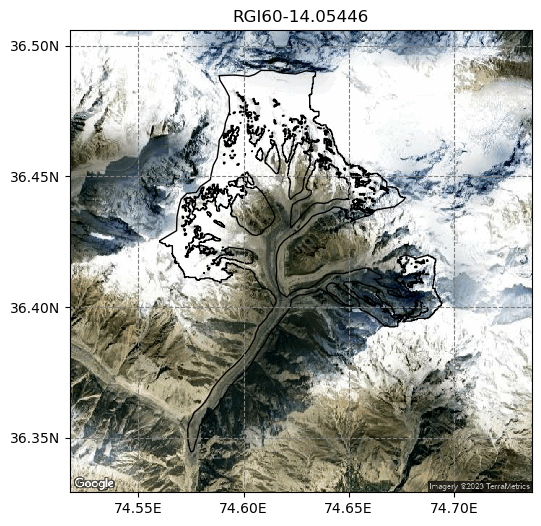

In [5]:
# Pick the glacier and plot it
gdir = gdirs[0]

f, ax = plt.subplots(1,1,figsize=(6, 6))
graphics.plot_googlemap(gdir, ax=ax)
ax.set_title(gdir.rgi_id);

## Calibrated mass balance parameters in the OGGM pre-processed directories

We just downloaded the data. Let's have a look at the climate data we used and the calibrated parameters:

In [6]:
gdir.get_climate_info()

{'baseline_climate_source': 'GSWP3_W5E5',
 'baseline_yr_0': 1901,
 'baseline_yr_1': 2019,
 'baseline_climate_ref_hgt': 4217.0,
 'baseline_climate_ref_pix_lon': 74.75,
 'baseline_climate_ref_pix_lat': 36.25}

This is called the "baseline climate" in OGGM and is necessary to calibrate the model against observations. Ideally, the baseline climate should be real observations as perfect as possible, but in reality this is not the case. Often, gridded climate datasets have biases - we need to take this into accound during our calibration. Let's have a look at the mass balance parameters for both glaciers:

In [7]:
mb_calib = gdir.read_json('mb_calib')  # read the calibrated parameters
mb_calib

{'rgi_id': 'RGI60-14.05446',
 'bias': 0,
 'melt_f': 2.606950221783511,
 'prcp_fac': 5.685822941608611,
 'temp_bias': -6.591488988717475,
 'reference_mb': -10.3,
 'reference_mb_err': 115.0,
 'reference_period': '2000-01-01_2020-01-01',
 'mb_global_params': {'temp_default_gradient': -0.0065,
  'temp_all_solid': 0.0,
  'temp_all_liq': 2.0,
  'temp_melt': -1.0},
 'baseline_climate_source': 'GSWP3_W5E5'}

We will explain later what these parameters mean. Lets focus on these for now: `melt_f`, `prcp_fac`, and `temp_bias` which have been calibrated with `reference_mb` over the reference period `reference_period`.

Per default the [Hugonnet et al. (2021)](https://www.nature.com/articles/s41586-021-03436-z) average geodetic observation is used over the entire time period Jan 2000 to Jan 2020 to calibrate the MB model parameter(s) for every single glacier.

## Plot the modelled mass balance time series 

OGGM provides a pre-calibrated mass-balance model. Let's use it:

In [11]:
mb_model = massbalance.MonthlyTIModel(gdir)

To compute the mass balance, we need to know the elevation and width of our glacier. OGGM gets this information from the model flowlines:

In [12]:
# Read the model flowlines for the plot
fls = gdir.read_pickle('model_flowlines')
heights = fls[0].surface_h

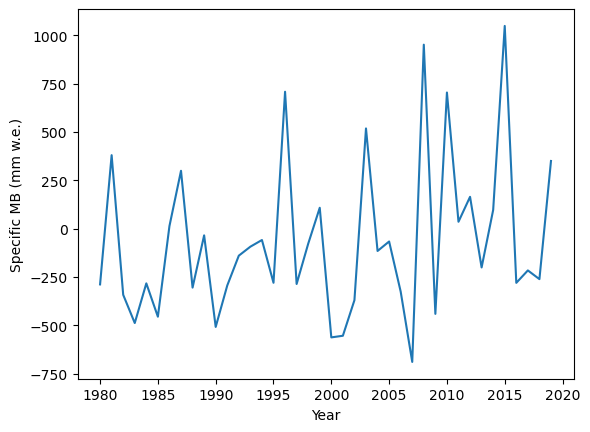

In [13]:
# We want to compute the mass balance for the years 1980-2020
years = np.arange(1980, 2020)

# Let's compute it
mb_ts = mb_model.get_specific_mb(fls=fls, year=years)

# And plot it
plt.plot(years, mb_ts);
plt.ylabel('Specific MB (mm w.e.)');
plt.xlabel('Year');

How do we compare to the satellite "observations"? Let's add them to the plot:

In [14]:
ref_mb = mb_calib['reference_mb']
ref_mb_err = mb_calib['reference_mb_err']

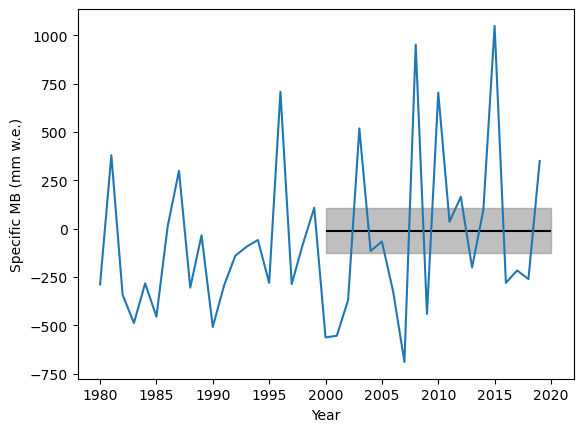

In [15]:
plt.fill_between([2000, 2020], ref_mb+ref_mb_err, ref_mb-ref_mb_err, color='grey', alpha=0.5)
plt.hlines([ref_mb], 2000, 2020, color='k')
plt.plot(years, mb_ts);
plt.ylabel('Specific MB (mm w.e.)');
plt.xlabel('Year');

Note that the error bar here does not represent inter-annual variability, but the error of the estimated average over 2000-2020.

## Plot the mass balance profiles

For completeness, let's also show two mass balance profiles as computed by the model:

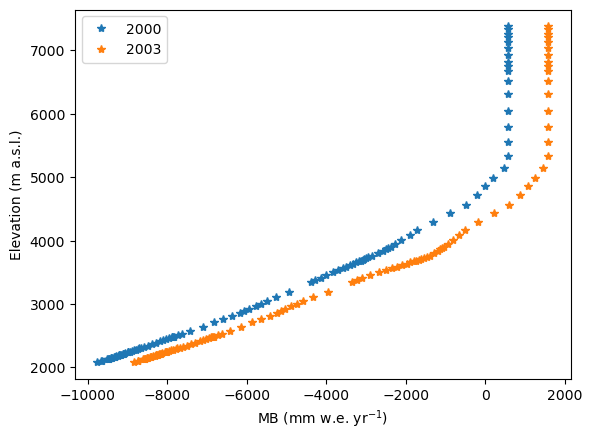

In [17]:
# First selected year
sel_year = 2000
mb = mb_model.get_annual_mb(heights, year=sel_year)
# convert units from kg ice per second to mm w.e. per year:
mb = mb * cfg.SEC_IN_YEAR * cfg.PARAMS['ice_density'] 
plt.plot(mb, heights, '*', label=sel_year);

# Another year:
sel_year = 2003
mb = mb_model.get_annual_mb(heights, year=sel_year)
mb = mb * cfg.SEC_IN_YEAR * cfg.PARAMS['ice_density'] 
# Plot
plt.plot(mb, heights, '*', label=sel_year);
plt.ylabel('Elevation (m a.s.l.)'); plt.xlabel('MB (mm w.e. yr$^{-1}$)'); plt.legend();

## Interpretation of the chosen parameters

<div class="alert alert-info">
    <b>
        How are these parameters calibrated by OGGM? Do they make sense, and how were they chosen? Let's discuss in class.
    </b>
</div>

Note also that there are some global MB parameters (`mb_global_params`), which we assume to be the same globally for every glacier:

In [18]:
gdir.read_json('mb_calib')['mb_global_params']

{'temp_default_gradient': -0.0065,
 'temp_all_solid': 0.0,
 'temp_all_liq': 2.0,
 'temp_melt': -1.0}

These global MB parameter values were found to represent best the in-situ observations during a cross-validation for glaciers with additional observations. Of course, they could also be changed for different glaciers, but this would need even more data to justify the differences! The influence of using a different temperature lapse rate gradient to the default -0.0065 K/km are analysed in [Schuster et al. (2023, in review)](https://doi.org/10.31223/X5C65S).

## Sensitivity analysis of the parameters 

Let's start by using the same mass balance model, but with the global default, non-calibrated OGGM parameters:

In [19]:
# The "naive" model uses simple first guesses for the model parameters: no climate correction, melt factor of 5
mbmod_naive = massbalance.MonthlyTIModel(gdir, temp_bias=0, prcp_fac=1, melt_f=5.)

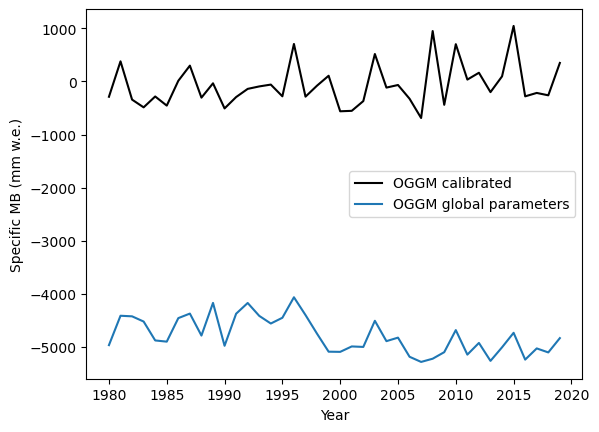

In [24]:
# Let's compute it for the same years at the other model
mb_ts_naive = mbmod_naive.get_specific_mb(fls=fls, year=years)

plt.plot(years, mb_ts, label='OGGM calibrated', color='k');
plt.plot(years, mb_ts_naive, label='OGGM global parameters');
plt.ylabel('Specific MB (mm w.e.)'); plt.xlabel('Year');
plt.legend();

Wow! This is really far from the observations! Simply assumming the mass balance parameter does not work in the majority of the cases.

**The process of "calibration" refers to finding the optimal parameters so that the observations are matched. There are automated ways to do this, but first we will vary the parameters and see their influence.**

Let vary the melt factor first:

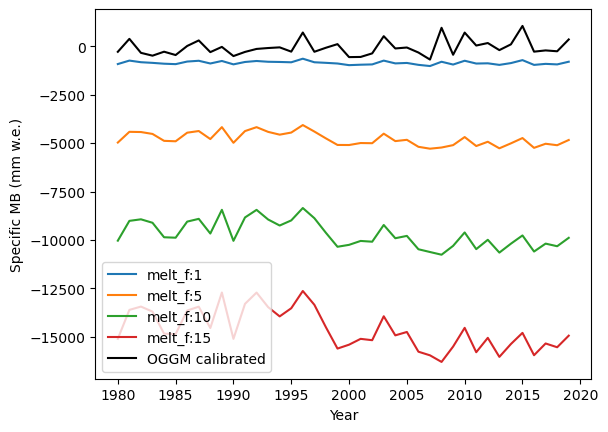

In [25]:
# Vary between 1 (extremely low) and 15 (very high)
for melt_factor in [1, 5, 10, 15]:
    mbmod_new = massbalance.MonthlyTIModel(gdir, temp_bias=0, prcp_fac=1, melt_f=melt_factor)
    mb_ts_new = mbmod_new.get_specific_mb(fls=fls, year=years)
    plt.plot(years, mb_ts_new, label=f'melt_f:{melt_factor}');
plt.plot(years, mb_ts, label='OGGM calibrated', color='k');
plt.ylabel('Specific MB (mm w.e.)'); plt.xlabel('Year'); plt.legend();

It's even worse! The high melt factors are very far from optimal.

**Activity: copy the code above and, this time, change the temperature bias parameters to `[-2, -4, -6, -8]`, while keeping the melt factor constant at 5 and precipitation factor at 1. Plot the result.**

In [80]:
# Your answer here

<div class="alert alert-success">
<details><summary><b>Can't go any further?</b> <i>Click for the answer</i></summary>
<code>
# Vary between 1 (extremely low) and 15 (very high)<br>
for temp_bias in [-2, -4, -6, -8]:<br>
    mbmod_new = massbalance.MonthlyTIModel(gdir, temp_bias=temp_bias, prcp_fac=1, melt_f=melt_factor)<br>
    mb_ts_new = mbmod_new.get_specific_mb(fls=fls, year=years)<br>
    plt.plot(years, mb_ts_new, label=f'temp_bias:{temp_bias}');<br>
plt.plot(years, mb_ts, label='OGGM calibrated', color='k');<br>
plt.ylabel('Specific MB (mm w.e.)'); plt.xlabel('Year'); plt.legend();
</code>
</div>

**Activity: copy the code above and, this time, change the precipitation factor parameters to `[1, 3, 6, 9]`, while keeping the melt factor constant at 5 and temperature bias at 0. Plot the result.**

In [80]:
# Your answer here

<div class="alert alert-success">
<details><summary><b>Can't go any further?</b> <i>Click for the answer</i></summary>
<code>
# Vary between 1 (unchanged precip) and 9 (very high precip)<br>
for prcp_fac in [1, 3, 6, 9]:<br>
    mbmod_new = massbalance.MonthlyTIModel(gdir, temp_bias=0, prcp_fac=prcp_fac, melt_f=5)<br>
    mb_ts_new = mbmod_new.get_specific_mb(fls=fls, year=years)<br>
    plt.plot(years, mb_ts_new, label=f'prcp_fac:{prcp_fac}');<br>
plt.plot(years, mb_ts, label='OGGM calibrated', color='k');<br>
plt.ylabel('Specific MB (mm w.e.)'); plt.xlabel('Year'); plt.legend();<br>
</code>
</div>

## Automated calibration 

Because it is very tedious to find the optimal parameters manually like we did above, OGGM offers ways to calibrate the parameters automatically. This is the purpose of the `mb_calibration_` tasks and will be discussed in the training:

In [33]:
from oggm.core.massbalance import mb_calibration_from_scalar_mb

In [35]:
optimal_params_2 = mb_calibration_from_scalar_mb(gdir, ref_mb=mb_calib['reference_mb'], write_to_gdir=False,  
                                                 ref_period='2000-01-01_2019-31-12',
                                                 calibrate_param1='melt_f',
                                                 calibrate_param2='temp_bias')

2023-03-14 08:54:50: oggm.core.massbalance: (RGI60-14.05446) mb_calibration_from_scalar_mb


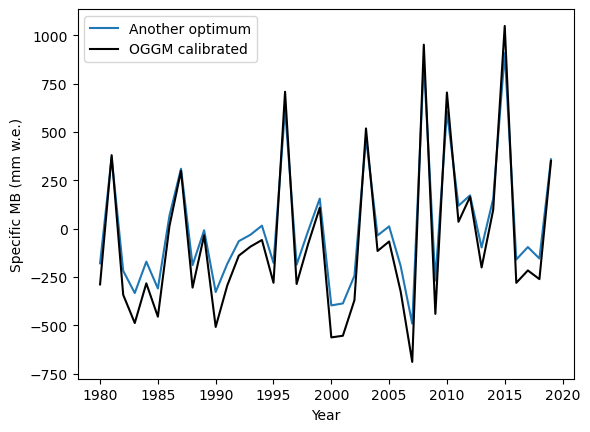

In [36]:
optim_model_2 = massbalance.MonthlyTIModel(gdir, 
                                           temp_bias=optimal_params_2['temp_bias'], 
                                           prcp_fac=optimal_params_2['prcp_fac'], 
                                           melt_f=optimal_params_2['melt_f'])

mb_ts_2  = optim_model_2.get_specific_mb(fls=fls, year=years)
plt.plot(years, mb_ts_2, label=f'Another optimum');
plt.plot(years, mb_ts, label='OGGM calibrated', color='k');
plt.ylabel('Specific MB (mm w.e.)'); plt.xlabel('Year'); plt.legend();

## Take home points 

The three mass balance parameters have a very difference influence on the simulated mass balance. We will discuss all of them during the training.

If you want to go further, visit our [full tutorial on mass balance calibration](https://oggm.org/tutorials/stable/notebooks/advanced/massbalance_calibration.html) on the OGGM website.